3.8783185840707963


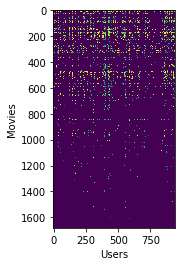

22.224603725685675
[ -2.52899165  -0.56819597  -0.83240713  -0.38358278  -0.80378006
   7.57570308   3.35265031   4.91163297   2.26333698   4.74271842
  -1.89979026  -0.52339845  -0.76677878  -0.35334048  -0.74040871
 -10.5680202   -3.05099006   0.           0.           4.62776019
   1.16441367   0.           0.          -7.16004443  -3.47410789
   0.           0.        ]
31.34405624427422
[ -0.95596339   0.60308088   0.12985616   0.29684395   0.60252677
   6.97535514   2.77421145   4.0898522    1.06300933   4.90185327
  -0.10861109   0.25839822  -0.89247334   0.66738144  -0.19747928
 -10.13985478  -2.29347024  -0.64787484   1.09289758   2.10136256
   0.48244098  -0.71820673  -0.40784086  -6.76563628  -2.99791422
   1.27006666   0.49026541]
         Current function value: 72005.230390
         Iterations: 100
         Function evaluations: 158
         Gradient evaluations: 158
Predicting rating 6.4 for movie Titanic (1997)
Predicting rating 7.4 for movie Star Wars (1977)
Predicting

In [1]:
%matplotlib inline
import sys

from numpy import *

import scipy.io, scipy.misc, scipy.optimize
from matplotlib import pyplot, cm, colors, lines
from mpl_toolkits.mplot3d import Axes3D

EX_DIRECTORY_PATH = './data/'

def loadMovieList():
    movies = {}
    counter = 0
    with open(EX_DIRECTORY_PATH + 'movie_ids.txt', 'r', encoding = "ISO-8859-1") as f:
        contents = f.readlines()
        for content in contents:
            movies[counter] = content.strip().split(' ', 1)[1]
            counter += 1

    return movies

def normalizeRatings( Y, R ):
    m = shape( Y )[0]
    Y_mean = zeros((m, 1))
    Y_norm = zeros( shape( Y ) )

    for i in range( 0, m ):
        idx             = where( R[i] == 1 )
        Y_mean[i]         = mean( Y[i, idx] )
        Y_norm[i, idx]     = Y[i, idx] - Y_mean[i]

    return Y_norm, Y_mean

def unrollParams( params, num_users, num_movies, num_features ):
    X         = params[:num_movies * num_features]
    X         = X.reshape( (num_features, num_movies) ).transpose()
    theta     = params[num_movies * num_features:]
    theta     = theta.reshape( num_features, num_users ).transpose()
    return X, theta
    
def cofiGradFunc( params, Y, R, num_users, num_movies, num_features, lamda ):
    X, theta     = unrollParams( params, num_users, num_movies, num_features )
    inner         = X.dot( theta.T ) * R - Y
    X_grad         = inner.dot( theta ) + lamda * X
    theta_grad     = inner.T.dot( X ) + lamda * theta
    return r_[X_grad.T.flatten(), theta_grad.T.flatten()]

            
def cofiCostFunc( params, Y, R, num_users, num_movies, num_features, lamda ):
    X, theta        = unrollParams( params, num_users, num_movies, num_features  )
    J                = 0.5 * sum( (X.dot( theta.T ) * R - Y) ** 2 )
    regularization = 0.5 * lamda * (sum( theta**2 ) + sum(X**2))
    return J + regularization

def part2_1():
    mat = scipy.io.loadmat(EX_DIRECTORY_PATH + 'ex8_movies.mat')
    Y, R = mat['Y'], mat['R']

    print(mean( extract ( Y[0,:] * R[0,:] > 0, Y[0, :] ) ))

    pyplot.imshow( Y )
    pyplot.ylabel( 'Movies' )
    pyplot.xlabel( 'Users')
    pyplot.show()

def part2_2():
    mat = scipy.io.loadmat(EX_DIRECTORY_PATH + 'ex8_movies.mat')
    Y, R = mat['Y'], mat['R']

    mat = scipy.io.loadmat(EX_DIRECTORY_PATH + 'ex8_movieParams.mat')
    num_features = mat['num_features']
    num_users      = mat['num_users']
    num_movies      = mat['num_movies']
    X              = mat['X']
    theta          = mat['Theta']

    num_users    = 4
    num_features = 3
    num_movies      = 5

    X         = X[:num_movies, :num_features]
    theta     = theta[:num_users, :num_features]
    Y         = Y[:num_movies, :num_users]
    R         = R[:num_movies, :num_users]


    params = r_[X.T.flatten(), theta.T.flatten()]
    print(cofiCostFunc( params, Y, R, num_users, num_movies, num_features, 0 ))
    print(cofiGradFunc( params, Y, R, num_users, num_movies, num_features, 0 ))
    print(cofiCostFunc( params, Y, R, num_users, num_movies, num_features, 1.5 ))
    print(cofiGradFunc( params, Y, R, num_users, num_movies, num_features, 1.5 ))


def part2_3():
    movies = loadMovieList()

    my_ratings = zeros((1682, 1))
    my_ratings[0] = 4
    my_ratings[97] = 2
    my_ratings[6]  = 3
    my_ratings[11] = 5
    my_ratings[53] = 4
    my_ratings[63] = 5
    my_ratings[65] = 3
    my_ratings[68] = 5
    my_ratings[182] = 4
    my_ratings[225] = 5
    my_ratings[354] = 5
    
    # for i in range( 0, 1682 ):
    #     if my_ratings[i] > 0:
    #         print "Rated %d for %s" % (my_ratings[i], movies[i])

    mat = scipy.io.loadmat(EX_DIRECTORY_PATH + 'ex8_movies.mat')
    Y, R = mat['Y'], mat['R']

    Y = c_[my_ratings, Y]
    R = c_[my_ratings > 0, R]

    Y_norm, Y_mean = normalizeRatings( Y, R )

    num_movies, num_users = shape( Y )
    num_features = 10


    X         = random.randn( num_movies, num_features )
    theta     = random.randn( num_users, num_features )
    initial_params = r_[X.T.flatten(), theta.T.flatten()]


    lamda = 10.0


    result = scipy.optimize.fmin_cg( cofiCostFunc, fprime=cofiGradFunc, x0=initial_params, \
                                    args=( Y, R, num_users, num_movies, num_features, lamda ), \
                                    maxiter=100, disp=True, full_output=True )
    J, params = result[1], result[0]

    X, theta = unrollParams( params, num_users, num_movies, num_features )
    prediction = X.dot( theta.T )

    my_prediction = prediction[:, 0:1] + Y_mean
    
    idx = my_prediction.argsort(axis=0)[::-1]
    my_prediction = my_prediction[idx]


    for i in range(0, 10):
        j = idx[i, 0]
        print("Predicting rating %.1f for movie %s" % (my_prediction[j], movies[j]))



def main():
    part2_1()
    part2_2()
    part2_3()


if __name__ == '__main__':
    main()